In [1]:
import os

from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
from matplotlib.pyplot import contourf
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.distributions import ImproperUniform, constraints
from numpyro.infer import MCMC, NUTS, HMCECS

import h5py

# Load the KMeans class:
from sklearn.cluster import KMeans
# import Gaussian Mixtures class
from sklearn.mixture import GaussianMixture

plt.style.use("bmh")
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

#assert numpyro.__version__.startswith("0.9.1")

import jax.numpy as jnp
from jax import grad, jit, vmap

# need rng)key to work in numpyro
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

This example is also found in the Bayesian-Pinns paper

We will study the 2D Allen-Cahn equation given by

$$
\epsilon\nabla^2\phi -  \phi(\phi^2-1) + f = 0
$$
on the domain $\Omega = [-1,1]\times[-1,1]$. We select $\epsilon=0.01$ as the mobility and use the exact solution $\phi(x,y) =2\exp(-(x^2+y^2))\sin(\pi x)\sin(\pi y)$

To derive the physics-informed functional prior, we must first find the PDE energy of the above. Following https://web.stanford.edu/~ochodosh/AllenCahnSummerSchool2019.pdf, it is 

$$
U_{\epsilon}[\phi] = \int_{\Omega}d\Omega\left(\frac{\epsilon}{2}||\nabla\phi||^2 + \frac{1}{4}(1-\phi^2)^2 - f\phi\right)
$$

So, our physics-informed prior is 
$$
p(\phi) \propto \exp\left\{-\beta U_{\epsilon}[\phi]\right\}
$$

Plugging in the exact solution to the PDE reveals the forcing term

In [2]:
# setting up the exact solution
eps = 0.01

# domain
Ox = jnp.linspace(-1., 1., 32)
Oy = jnp.linspace(-1., 1., 32)
X, Y = jnp.meshgrid(Ox, Oy)
# exact soln.
# 
phi_exact = lambda x, y: 2*jnp.exp(-(x**2+y**2))*jnp.sin(jnp.pi*x)*jnp.sin(jnp.pi*y)

vphi_exact = vmap(phi_exact, in_axes = (0, 0))

In [3]:
gex_x = grad(phi_exact, 0)
gex_y = grad(phi_exact, 1)
gex_xx = grad(gex_x, 0)
gex_yy = grad(gex_y, 1)

# forcing term is generated from the exact solution
f_exact = lambda x, y: -(eps*(gex_xx(x,y) + gex_yy(x,y)) - phi_exact(x,y)*(phi_exact(x,y)**2 - 1))

vf_exact = vmap(f_exact, (0,0))

## Choosing a "well-informed" basis

Before we parameterize the field with a proper set of basis functions, we consider the case where we choose the exact soln. and try to fit it.

In this case, the function we are trying to calibrate is

$$
\hat{\phi}(x;\theta) = \theta\exp(-(x^2+y^2))\sin(\pi x)\sin(\pi y),
$$
where we $\theta$ is the only parameter. In this case we know exactly what $\theta$ should be 2.

In this 1D situation, we are able to visulaize how the physics-informed prior chnages for different values of $\theta$. This reveals an unusual form of the prior:

In [4]:
phi = lambda x, y, theta: theta * jnp.exp(-(x**2+y**2)) * jnp.sin(jnp.pi*x)*jnp.sin(jnp.pi*y)
#

vphi = vmap(phi, in_axes = (0, 0, None))

# gradients
#gphi_x = lambda x, y, theta: jnp.pi * theta * jnp.cos(jnp.pi*x)*jnp.sin(jnp.pi*y)
#gphi_y = lambda x, y, theta: jnp.pi * theta * jnp.sin(jnp.pi*x)*jnp.cos(jnp.pi*y)
gphi_x = lambda x, y, theta: -2*theta*x*jnp.exp(-(x**2+y**2))*jnp.sin(jnp.pi*x)*jnp.sin(jnp.pi*y) + theta*jnp.pi*jnp.exp(-(x**2+y**2))*jnp.cos(jnp.pi*x)*jnp.sin(jnp.pi*y)
gphi_y = lambda x, y, theta: -2*theta*y*jnp.exp(-(x**2+y**2))*jnp.sin(jnp.pi*x)*jnp.sin(jnp.pi*y) + theta*jnp.pi*jnp.exp(-(x**2+y**2))*jnp.sin(jnp.pi*x)*jnp.cos(jnp.pi*y)

In [5]:
E = lambda x, y, theta: 0.5*eps*(gphi_x(x,y,theta)**2+gphi_y(x,y,theta)**2) + 0.25*(1-phi(x,y,theta)**2)**2 - phi(x,y,theta)*f_exact(x,y)


vE = vmap(E, in_axes = (0, 0, None))

log_prior = lambda beta, theta, xs, ys: -beta * jnp.mean(vE(xs, ys, theta))

In [6]:
thetas = jnp.linspace(-3.5,3.5,100)
E_theta = jnp.zeros(100)
for i in range(100):
    # picking beta = 100 (strong trust in the physics)
    E_theta = E_theta.at[i].set(-100 * jnp.mean(vE(X.flatten(), Y.flatten(), thetas[i])))

In [7]:
sns.set_context("paper")
sns.set_style("white")
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {'text.usetex' : True,
          'font.size' : 9,
          'font.family' : 'lmodern'
          }
plt.rcParams.update(params)

<ipython-input-7-3f48bfc56603>:3: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]


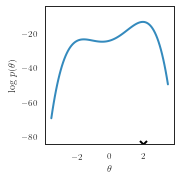

In [8]:
plt.figure(figsize = [5.1667/2, 5.1667/2])

plt.plot(thetas, E_theta, lw = 2)
plt.ylim([-85, -5])
plt.xlabel(r'$\theta$', fontsize = 10)
plt.ylabel(r'$\log$ $p(\theta)$', fontsize = 10)
plt.plot(2, -85, 'kx', markersize = 7, markeredgewidth=2)
plt.tight_layout()
#plt.savefig('ACenergy.pdf', dpi = 500)

In [118]:
h5f = h5py.File('example4_energydata.h5','r')

In [119]:
h5f.keys()

<KeysViewHDF5 ['E(theta)', 'thetas']>

In [15]:
h5f = h5py.File('example4_energydata.h5','w')
h5f.create_dataset('thetas', data = thetas)
h5f.create_dataset('E(theta)', data = E_theta)
h5f.close()

This reveals a bimodal posterior, with high probability at the true solution

Next we use a general basis. We stick with the Fourier series, but this time in 2D on [-1,1]x[-1,1].
We select an equal number of sine and cosine terms, chosing 2 each, which results in $(2*2-1)^2=9$ total parameters

In [9]:
# First we define the fourier basis

n = 2 # input how many sine and cosine terms you want EACH
print((2*n-1)**2)
# fourier series on [0,1]
def fourier_basis(x,m=n):
    tmp = jnp.pi * jnp.arange(1, m) * x
    return jnp.hstack([jnp.ones(()), jnp.cos(tmp), jnp.sin(tmp)])

phi = lambda x, y, w: jnp.sum(jnp.kron(fourier_basis(x), fourier_basis(y))*w)
# vectorized phi
vphi = vmap(phi, in_axes = (0, 0, None))

9


In [10]:
# gradients

# first derivatives for exact energy
gphi_x = grad(phi, 0)
gphi_y = grad(phi, 1)

# second derivatives for square residual
gphi_x2 = grad(gphi_x, 0)
gphi_y2 = grad(gphi_y, 1)

In [11]:
# exact energy here
E = lambda x, y, theta: 0.5*eps*(gphi_x(x,y,theta)**2+gphi_y(x,y,theta)**2) + 0.25*(1-phi(x,y,theta)**2)**2 - phi(x,y,theta)*f_exact(x,y)

# square residual here
#E = lambda x, y, theta: (eps*(gphi_x2(x,y,theta) + gphi_y2(x,y,theta)) - phi(x,y,theta)*(phi(x,y,theta)-1)**2 + f_exact(x,y))**2


vE = vmap(E, in_axes = (0, 0, None))

# physics-informed prior
log_prior = lambda beta, theta, xs, ys: -beta * jnp.mean(vE(xs, ys, theta))

Next we generate measurements of the boundaries

In [65]:
sigma = 0.01
num_each = 15
num = num_each*3

x_ticks = jnp.zeros(num)
y_ticks = jnp.zeros(num)
phi_measurements = jnp.zeros(num)

# bottom boundary
for i in range(num_each):
    x_ticks = x_ticks.at[i].set(np.random.uniform(low = -1, high = 1))
    y_ticks = y_ticks.at[i].set(-1.)
    phi_measurements = phi_measurements.at[i].set(phi_exact(x_ticks[i], y_ticks[i])+np.random.normal(loc = 0.0, scale = sigma) )
    
# top    
for i in range(num_each):
    x_ticks = x_ticks.at[num_each+i].set(np.random.uniform(low = -1, high = 1))
    y_ticks = y_ticks.at[num_each+i].set(1.)
    phi_measurements = phi_measurements.at[num_each+i].set(phi_exact(x_ticks[num_each+i], y_ticks[num_each+i])+np.random.normal(loc = 0.0, scale = sigma) )

# right
for i in range(num_each):
    y_ticks = y_ticks.at[2*num_each+i].set(np.random.uniform(low = -1, high = 1))
    x_ticks = x_ticks.at[2*num_each+i].set(1)
    phi_measurements = phi_measurements.at[2*num_each+i].set(phi_exact(x_ticks[2*num_each+i], y_ticks[2*num_each+i])+np.random.normal(loc = 0.0, scale = sigma) )

# left
#for i in range(num_each):
#    y_ticks = y_ticks.at[3*num_each+i].set(np.random.uniform(low = -1., high = 1.))
#    x_ticks = x_ticks.at[3*num_each+i].set(-1.)
#    phi_measurements = phi_measurements.at[3*num_each+i].set(phi_exact(x_ticks[3*num_each+i], y_ticks[3*num_each+i])+np.random.normal(loc = 0.0, scale = sigma) )

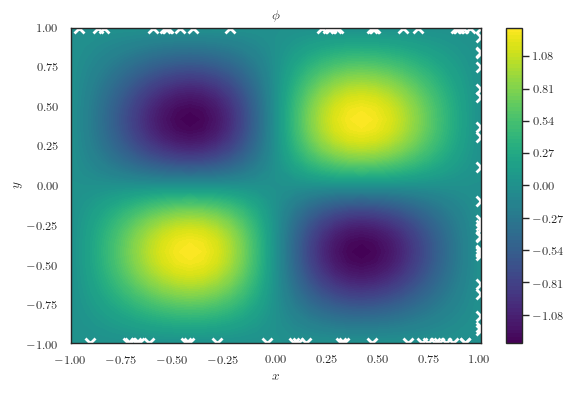

In [13]:
plt.figure(dpi = 100)

plt.contourf(X, Y, vphi_exact(X, Y), 100, cmap = 'viridis')
plt.plot(x_ticks, y_ticks, 'wx', markersize = 7, markeredgewidth = 2)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$\phi$')
plt.colorbar()

plt.tight_layout()

In [12]:
# generates measurements in the domain
# start by generating measurements from the real solution
Ox = jnp.linspace(-1., 1., 1000)
Oy = jnp.linspace(-1., 1., 1000)
sigma = 0.01 # std
num = 10
x_ticks_inner = jnp.zeros(num)
y_ticks_inner = jnp.zeros(num)
ticks_x = random.randint(key = rng_key, shape = (num,), minval = 0, maxval = 1000)
ticks_y = random.randint(key = rng_key_, shape = (num,), minval = 0, maxval = 1000)
phi_ticks = jnp.zeros(num)
phi_measurements_inner = jnp.zeros(num)
for i in range(num):
    x_ticks_inner = x_ticks_inner.at[i].set(Ox[ticks_x[i]])
    y_ticks_inner = y_ticks_inner.at[i].set(Oy[ticks_y[i]])
    phi_ticks = phi_ticks.at[i].set(phi_exact(x_ticks_inner[i], y_ticks_inner[i]))
    
    # and add a bit of noies to create measurements
    phi_measurements_inner = phi_measurements_inner.at[i].set(phi_ticks[i] + np.random.normal(loc = 0.0, scale = sigma))

Ox = jnp.linspace(-1., 1., 32)
Oy = jnp.linspace(-1., 1., 32)

In [13]:
x_ticks = jnp.append(x_ticks, x_ticks_inner)
y_ticks = jnp.append(y_ticks, y_ticks_inner)
phi_measurements = jnp.append(phi_measurements, phi_measurements_inner )

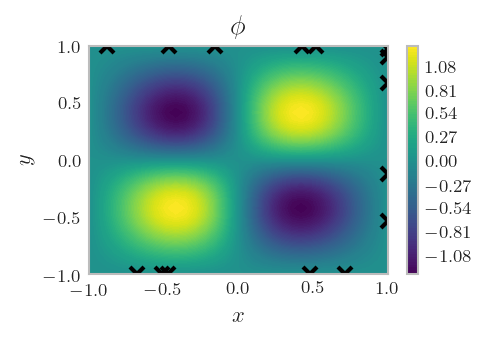

In [20]:
plt.figure(dpi = 150)

plt.subplot(2,2,1)
plt.contourf(X, Y, vphi_exact(X, Y), 100, cmap = 'viridis')
plt.plot(x_ticks, y_ticks, 'kx', markersize = 7, markeredgewidth = 2)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$\phi$')
plt.colorbar()

#plt.subplot(2,2,2)
#plt.contourf(X, Y, vf_exact(X.flatten(), Y.flatten()).reshape(1000,1000), 100, cmap = 'viridis')
#plt.plot(x_ticks, y_ticks, 'kx', markersize = 7, markeredgewidth = 2)
#plt.xlabel('$x$')
##plt.ylabel('$y$')
#plt.title('$f$')

#plt.colorbar()
plt.tight_layout()

In [111]:
h5f = h5py.File('example4measurements.h5','w')
h5f.create_dataset('xs', data = x_ticks)
h5f.create_dataset('ys', data = y_ticks)
h5f.create_dataset('obs', data = phi_measurements)
h5f.close()

To estimate the energy we are going to perform the integral through a subsampling scheme. At each iteration, we pick a random batch of points in the domain of integration and evaluate the mean integrand at those points

In [66]:
# make the domain:

xs = jnp.linspace(-1,1,1000000)
ys = jnp.linspace(-1,1,1000000)

In [67]:
# model used for numpyro inference

def model(data=None, beta=None, batch_size = None):

    # grab the batch of points in the domain
    with numpyro.plate("batched_x", len(xs), subsample_size = batch_size ):
        Xs = numpyro.subsample(xs, event_dim = 0)
    with numpyro.plate("batched_y", len(ys), subsample_size = batch_size ):
        Ys = numpyro.subsample(ys, event_dim = 0)
    
    #theta = numpyro.sample("theta", dist.ImproperUniform(constraints.real, (), event_shape = ( (2*n-1)**2, )) )
    theta = numpyro.sample("theta", dist.Normal(0., 1.), sample_shape =  ((2*n-1)**2,) ) 
    
    numpyro.factor("prior", log_prior(beta, theta, Xs, Ys))
    phi_model = vphi(x_ticks, y_ticks, theta)
    
    with numpyro.plate('observed_data', len(data)):

        return numpyro.sample('obs', dist.Normal(loc = phi_model, scale = sigma), obs = data)

In [71]:
# do the numpyro inference - using NUTS as inner kernel for the algorithm
inner_kernel = NUTS(model)
kernel = HMCECS(inner_kernel)
mcmc = MCMC(kernel, num_warmup = 1000, num_samples = 100000)
mcmc.run(rng_key = rng_key, data = phi_measurements, beta = 50, batch_size = 8)
mcmc.print_summary()

sample: 100%|██████████| 101000/101000 [05:42<00:00, 294.70it/s, 47 steps of size 5.16e-03. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.14      0.14      0.16     -0.09      0.35     28.98      1.05
  theta[1]      0.14      0.14      0.16     -0.09      0.35     28.99      1.05
  theta[2]      0.30      0.19      0.34     -0.06      0.56     19.99      1.06
  theta[3]      0.14      0.14      0.16     -0.09      0.35     28.98      1.05
  theta[4]      0.14      0.14      0.16     -0.10      0.34     28.99      1.05
  theta[5]      0.29      0.19      0.34     -0.07      0.55     19.99      1.06
  theta[6]     -0.17      0.16     -0.19     -0.42      0.10     66.70      1.02
  theta[7]     -0.17      0.16     -0.19     -0.42      0.10     66.72      1.02
  theta[8]      1.05      0.22      1.02      0.72      1.44     36.31      1.04



In [72]:
# grab the samples
samples = mcmc.get_samples()['theta']

Text(0.5, 0, 'iter')

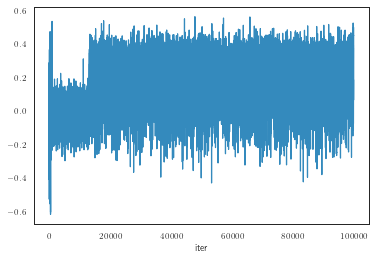

In [73]:
fig, ax = plt.subplots()
# look at some MCMC chains
plt.plot(samples[:,0])
plt.xlabel('iter')

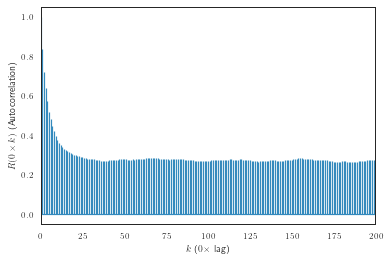

In [74]:
# look at autocorrelation

fig, ax = plt.subplots()
ax.acorr(samples[:, 0], detrend = plt.mlab.detrend_mean, maxlags = 200)
ax.set_xlim(0,200)
ax.set_ylabel(r'$R(%d \times k)$ (Autocorrelation)' % 0)
ax.set_xlabel(r'$k$ ($%d \times$ lag)' % 0);

In [75]:
Theta = samples[0:-1:25,:]
thin = Theta.shape[0]
print(thin)

4000


Text(0.5, 0, 'iter')

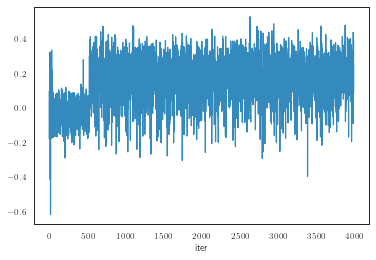

In [76]:
# look at the thinned chains
fig, ax = plt.subplots()
plt.plot(Theta[:,0])
plt.xlabel('iter')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

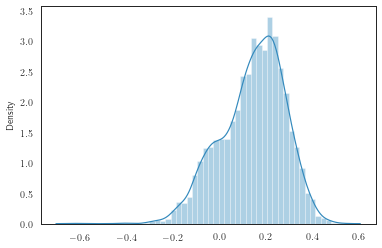

In [77]:
plt.figure()
sns.distplot(Theta[:,0], 50)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
#plt.xlabel("theta_0", fontsize = 10)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'theta2')

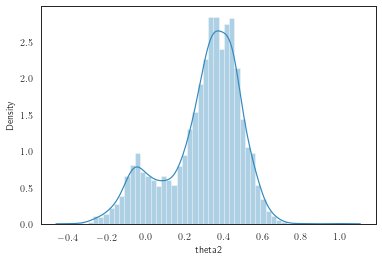

In [78]:
plt.figure()
sns.distplot(Theta[:,2], 50)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel("theta2", fontsize = 10)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


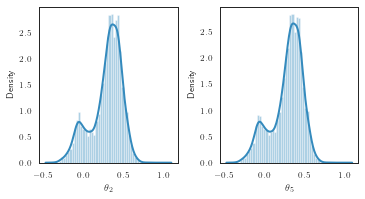

In [105]:
plt.rcParams.update({'font.size': 9})
sns.set_context("paper")
sns.set_style("white")

plt.figure(figsize = [5.1667, 5.1667])
plt.rcParams.update({'lines.linewidth': 2.0})

plt.subplot(2,2,1)
sns.distplot(Theta[:,2], 50)
plt.xlabel(r'$\theta_2$', fontsize = 10.0)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
plt.ylabel('Density', fontsize = 9)
plt.tight_layout()

plt.subplot(2,2,2)
sns.distplot(Theta[:,5], 50)
plt.xlabel(r'$\theta_5$', fontsize = 10.0)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
plt.ylabel('Density', fontsize = 9)
plt.rcParams.update({'lines.linewidth': 2.0})
plt.tight_layout()

plt.tight_layout()
#plt.savefig('2DAC-posts.pdf', dpi = 500)

In [107]:
h5f = h5py.File('example4bimodalthetas.h5','w')
h5f.create_dataset('theta_2', data = Theta[:,2])
h5f.create_dataset('theta_5', data = Theta[:,5])
h5f.close()

K-means

Gaussian Mixtures

In [85]:
# Initialize and fit
GMmodel = GaussianMixture(n_components=2).fit(Theta)

In [86]:
modes = GMmodel.means_
print(modes)

[[-0.03449926 -0.03571236 -0.00671882 -0.03534721 -0.03955944 -0.01199742
   0.01970648  0.01751098  1.35982234]
 [ 0.19244404  0.19119026  0.37913554  0.19154779  0.18728565  0.37401233
  -0.22071978 -0.22281902  0.96239689]]


In [90]:
low_mode = vphi(X.flatten(), Y.flatten(), modes[0,:])
high_mode = vphi(X.flatten(), Y.flatten(), modes[1,:])
mean = vphi(X.flatten(), Y.flatten(), jnp.mean(Theta, axis = 0))
median = vphi(X.flatten(), Y.flatten(), jnp.quantile(Theta, q = 0.5, axis = 0))

In [108]:
h5f = h5py.File('example4posteriorsamples.h5', 'w')
h5f.create_dataset('xs', data = X)
h5f.create_dataset('ys', data = Y)
h5f.create_dataset('exact', data = vphi_exact(X,Y))
h5f.create_dataset('median', data = median.reshape(32,32))
h5f.create_dataset('mode_one', data = low_mode.reshape(32,32))
h5f.create_dataset('mode_two', data = high_mode.reshape(32,32))
h5f.close()

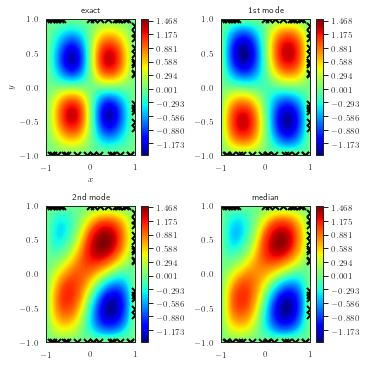

In [98]:
lvs = np.linspace(low_mode.min(), high_mode.max(), 1000)
plt.rcParams.update({'font.size': 9})
sns.set_context("paper")
sns.set_style("white")

plt.figure(figsize = [5.1667, 5.1667])

plt.subplot(2,2,1)
cnt1 = plt.contourf(X, Y, vphi_exact(X, Y), levels=lvs, cmap = 'jet')
# This is the fix for the white lines between contour levels
for c in cnt1.collections:
    c.set_edgecolor("face")
plt.plot(x_ticks, y_ticks, 'kx', markersize = 7, markeredgewidth = 2)
plt.xlabel('$x$', fontsize = 9)
plt.ylabel('$y$', fontsize = 9)
plt.title('exact', fontsize = 9)
plt.colorbar(orientation="vertical")
plt.tight_layout()


plt.subplot(2,2,2)
cnt2 = plt.contourf(X, Y, low_mode.reshape(32,32), levels=lvs, cmap = 'jet')
# This is the fix for the white lines between contour levels
for c in cnt2.collections:
    c.set_edgecolor("face")
plt.plot(x_ticks, y_ticks, 'kx', markersize = 7, markeredgewidth = 2)
plt.title('1st mode', fontsize = 9)
plt.colorbar(orientation="vertical")
plt.tight_layout()

plt.subplot(2,2,3)
cnt3 = plt.contourf(X, Y, high_mode.reshape(32,32), levels=lvs, cmap = 'jet')
# This is the fix for the white lines between contour levels
for c in cnt3.collections:
    c.set_edgecolor("face")
plt.plot(x_ticks, y_ticks, 'kx', markersize = 7, markeredgewidth = 2)
plt.title('2nd mode', fontsize = 9)
plt.colorbar(orientation="vertical")
plt.tight_layout()


plt.subplot(2,2,4)
cnt4 = plt.contourf(X, Y, median.reshape(32,32), levels=lvs, cmap = 'jet')
# This is the fix for the white lines between contour levels
for c in cnt4.collections:
    c.set_edgecolor("face")
plt.plot(x_ticks, y_ticks, 'kx', markersize = 7, markeredgewidth = 2)
plt.title('median', fontsize = 9)
plt.colorbar(orientation="vertical")
plt.tight_layout()


plt.tight_layout()

#plt.savefig('2DAC-solutions.pdf', dpi = 1000)

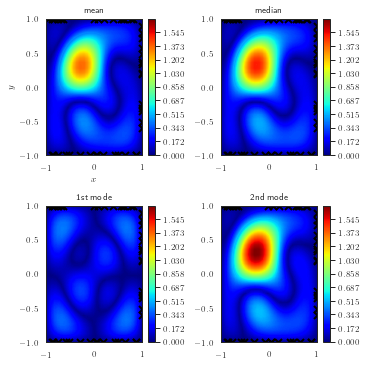

In [92]:
lvs = jnp.linspace(0,jnp.abs((vphi_exact(X, Y)-high_mode.reshape(32,32))).max(),1000)
plt.rcParams.update({'font.size': 9})
sns.set_context("paper")
sns.set_style("white")

plt.figure(figsize = [5.1667, 5.1667])

plt.subplot(2,2,1)
cnt1 = plt.contourf(X, Y, jnp.abs((vphi_exact(X, Y)-mean.reshape(32,32))), levels=lvs, cmap = 'jet')
# This is the fix for the white lines between contour levels
for c in cnt1.collections:
    c.set_edgecolor("face")
plt.plot(x_ticks, y_ticks, 'kx', markersize = 7, markeredgewidth = 2)
plt.xlabel('$x$', fontsize = 9)
plt.ylabel('$y$', fontsize = 9)
plt.title('mean', fontsize = 9)
plt.colorbar(orientation="vertical")
plt.tight_layout()


plt.subplot(2,2,2)
cnt2 = plt.contourf(X, Y, jnp.abs((vphi_exact(X, Y)-median.reshape(32,32))), levels=lvs, cmap = 'jet')
# This is the fix for the white lines between contour levels
for c in cnt2.collections:
    c.set_edgecolor("face")
plt.plot(x_ticks, y_ticks, 'kx', markersize = 7, markeredgewidth = 2)
plt.title('median', fontsize = 9)
plt.colorbar(orientation="vertical")
plt.tight_layout()

plt.subplot(2,2,3)
cnt3 = plt.contourf(X, Y, jnp.abs((vphi_exact(X, Y)-low_mode.reshape(32,32))), levels=lvs, cmap = 'jet')
# This is the fix for the white lines between contour levels
for c in cnt3.collections:
    c.set_edgecolor("face")
plt.plot(x_ticks, y_ticks, 'kx', markersize = 7, markeredgewidth = 2)
plt.title('1st mode', fontsize = 9)
plt.colorbar(orientation="vertical")
plt.tight_layout()


plt.subplot(2,2,4)
cnt4 = plt.contourf(X, Y, jnp.abs((vphi_exact(X, Y)-high_mode.reshape(32,32))), levels=lvs, cmap = 'jet')
# This is the fix for the white lines between contour levels
for c in cnt4.collections:
    c.set_edgecolor("face")
plt.plot(x_ticks, y_ticks, 'kx', markersize = 7, markeredgewidth = 2)
plt.title('2nd mode', fontsize = 9)
plt.colorbar(orientation="vertical")
plt.tight_layout()


plt.tight_layout()

#plt.savefig('2DAC-errors.pdf', dpi = 1000)

In [109]:
h5f = h5py.File('example4errors.h5', 'w')
h5f.create_dataset('xs', data = X)
h5f.create_dataset('ys', data = Y)
h5f.create_dataset('mean', data = jnp.abs((vphi_exact(X, Y)-mean.reshape(32,32))))
h5f.create_dataset('median', data = jnp.abs((vphi_exact(X, Y)-median.reshape(32,32))))
h5f.create_dataset('mode_one', data = jnp.abs((vphi_exact(X, Y)-low_mode.reshape(32,32))))
h5f.create_dataset('mode_two', data = jnp.abs((vphi_exact(X, Y)-high_mode.reshape(32,32))))
h5f.close()

In [1065]:
covs = GMmodel.covariances_
print(covs)

[[[0.10684993 0.1068039  0.00621297 0.10519559 0.10526574 0.005286
   0.15212782 0.15209055 0.02611307]
  [0.1068039  0.10677183 0.00619268 0.10519153 0.10525504 0.00530192
   0.1520615  0.15202333 0.02607905]
  [0.00621297 0.00619268 0.10759448 0.0060147  0.00601455 0.10740666
   0.02384362 0.02381738 0.15545639]
  [0.10519559 0.10519153 0.0060147  0.10582386 0.105825   0.0063991
   0.1505173  0.15048604 0.02643027]
  [0.10526574 0.10525504 0.00601455 0.105825   0.10585042 0.0063414
   0.15059035 0.15055653 0.02639737]
  [0.005286   0.00530192 0.10740666 0.0063991  0.0063414  0.10803054
   0.02294009 0.02291946 0.15553265]
  [0.15212782 0.1520615  0.02384362 0.1505173  0.15059035 0.02294009
   0.24538589 0.24533341 0.08394875]
  [0.15209055 0.15202333 0.02381738 0.15048604 0.15055653 0.02291946
   0.24533341 0.24530497 0.08391332]
  [0.02611307 0.02607905 0.15545639 0.02643027 0.02639737 0.15553265
   0.08394875 0.08391332 0.26418138]]

 [[0.01422047 0.0141941  0.00226136 0.01355338 0

In [1066]:
covs.shape

(2, 9, 9)

In [1068]:
modes.shape

(2, 9)

In [1070]:
mode_1 = np.random.multivariate_normal(mean = modes[1,:], cov = covs[1,:,:], size = 1000)

In [1071]:
mode_1.shape

(1000, 9)

In [1073]:
# now we try to generate the posterior by making a bunch of samples

phi_hat = jnp.zeros((1000, len(X.flatten())))

# array which contains all of the phi_hat samples
for i in range(1000):
    phi_hat = phi_hat.at[i, : ].set( vphi(X.flatten(), Y.flatten(), mode_1[i, :]) )

In [1074]:
median = jnp.quantile(phi_hat, q = 0.5, axis = 0)
low = jnp.quantile(phi_hat, q = 0.025, axis = 0)
high = jnp.quantile(phi_hat, q = 0.975, axis = 0)

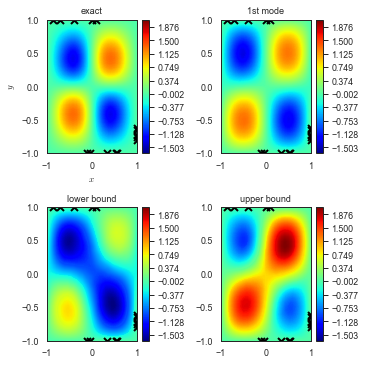

In [1132]:
lvs = jnp.linspace(low.min(), high.max(), 1000)
plt.rcParams.update({'font.size': 9})
sns.set_context("paper")
sns.set_style("white")

plt.figure(figsize = [5.1667, 5.1667])

plt.subplot(2,2,1)
cnt1 = plt.contourf(X, Y, vphi_exact(X, Y), levels = lvs, cmap = 'jet')
# This is the fix for the white lines between contour levels
for c in cnt1.collections:
    c.set_edgecolor("face")
plt.plot(x_ticks, y_ticks, 'kx', markersize = 7, markeredgewidth = 2)
plt.xlabel('$x$', fontsize = 9)
plt.ylabel('$y$', fontsize = 9)
plt.title('exact', fontsize = 9)
plt.colorbar(orientation="vertical")
plt.tight_layout()


plt.subplot(2,2,2)
cnt2 = plt.contourf(X, Y, low_mode.reshape(32,32), levels=lvs, cmap = 'jet')
# This is the fix for the white lines between contour levels
for c in cnt2.collections:
    c.set_edgecolor("face")
plt.plot(x_ticks, y_ticks, 'kx', markersize = 7, markeredgewidth = 2)
plt.title('1st mode', fontsize = 9)
plt.colorbar(orientation="vertical")
plt.tight_layout()

plt.subplot(2,2,3)
cnt3 = plt.contourf(X, Y, low.reshape(32,32), levels=lvs, cmap = 'jet')
# This is the fix for the white lines between contour levels
for c in cnt3.collections:
    c.set_edgecolor("face")
plt.plot(x_ticks, y_ticks, 'kx', markersize = 7, markeredgewidth = 2)
plt.title('lower bound', fontsize = 9)
plt.colorbar(orientation="vertical")
plt.tight_layout()


plt.subplot(2,2,4)
cnt4 = plt.contourf(X, Y, high.reshape(32,32), levels=lvs, cmap = 'jet')
# This is the fix for the white lines between contour levels
for c in cnt4.collections:
    c.set_edgecolor("face")
plt.plot(x_ticks, y_ticks, 'kx', markersize = 7, markeredgewidth = 2)
plt.title('upper bound', fontsize = 9)
plt.colorbar(orientation="vertical")
plt.tight_layout()


plt.tight_layout()
plt.savefig('2D-AC-predictive intervals.pdf', dpi = 1000)

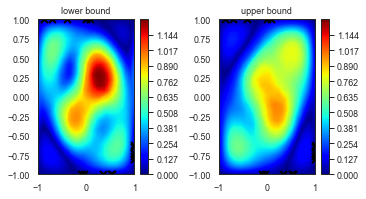

In [1133]:
lvs = jnp.linspace(0,jnp.abs((vphi_exact(X, Y)-low.reshape(32,32))).max(), 1000)
plt.rcParams.update({'font.size': 9})
sns.set_context("paper")
sns.set_style("white")

plt.figure(figsize = [5.1667, 5.1667])


plt.subplot(2,2,1)
cnt2 = plt.contourf(X, Y, jnp.abs((vphi_exact(X, Y)-low.reshape(32,32))), levels=lvs, cmap = 'jet')
# This is the fix for the white lines between contour levels
for c in cnt2.collections:
    c.set_edgecolor("face")
plt.plot(x_ticks, y_ticks, 'kx', markersize = 7, markeredgewidth = 2)
plt.title('lower bound', fontsize = 9)
plt.colorbar(orientation="vertical")
plt.tight_layout()

plt.subplot(2,2,2)
cnt3 = plt.contourf(X, Y, jnp.abs((vphi_exact(X, Y)-high.reshape(32,32))), levels=lvs, cmap = 'jet')
# This is the fix for the white lines between contour levels
for c in cnt3.collections:
    c.set_edgecolor("face")
plt.plot(x_ticks, y_ticks, 'kx', markersize = 7, markeredgewidth = 2)
plt.title('upper bound', fontsize = 9)
plt.colorbar(orientation="vertical")
plt.tight_layout()

plt.tight_layout()
plt.savefig('2D-AC-predictiveErrors.pdf', dpi = 1000)